Urban Data Science & Smart Cities <br>
URSP688Y Spring 2025<br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

# Exercise03

## Problem

In the last exercise, you used tabular analyses to examine how eviction impacts tenants in Montgomery and Prince George's Counties. In this exercise, you will use more precise, address-level data to analyze evictions across the entire state through a spatial lens.

**You get to write your own research question, but with a few parameters:**
- It should be addressable with the provided eviction data
- It should require that you relate the eviction data to at least one other dataset, which you provide
- It should involve at least one form of spatial analysis (e.g., proximity, overlay, or measurement of another spatial relationship)

**Please write a short abstract (200-300 words) at the top of your exercise notebook that concisely summarizes your research question, how you addressed it, and the results of your analysis. Then provide reproducible code in cells below.**

**Abstract:**

For exercise three, I sought to join the eviction data to census data for Maryland to investigate the relationship between disability and eviction rates. To do this, I first cleaned the eviction data so that it only contained cases where evictions actually occured in Montgomery & Prince George's county. I then pulled in census tract data, creating a geodataframe with the two counties and the count of the total number of people in each census tract with a disability. I then combined those two dataframes, using a spatial join, and created a dataframe containing the count of evictions and the number of individuals with a disability within a census tract. I then attempted to create a single, bivariate cloropleth map, with symbology showing where there were high concentrations of both counts, high concentrations of just one count, and areas where there were low concentrations of both counts. However, I was unable to fully solve the challenge of creating a bivariate cloropleth map, and decided to instead simply create a scatterplot betweem total disabled counts and evictions, to do a visual check on if there was any correlation, and there was not. Thus, the evidence does not support the hypothesis that tracts with greater disabled counts also have higher evictions, although it is interesting to note that PG county, slightly smaller than Montgomery county, nevertheless displays greater numbers in both categories.

### Bonus

Only a portion of the eviction records I'm providing for this exercise have addresses that can be geocoded (converting address strings to geographic coordinates) with a high degree of accuracy, or even at all. How could you assess bias in which records are accurately geocoded? (Hint: This will require you to define accuracy.) Can you write a Python script that evaluates whether higher- and lower-accuracy geocodes are randomly distributed across eviction records, or whether certain types of evictions are more or less likely to be geocoded well? **Please report your approach and findings in a separate paragraph and provide supporting code.**

## Data

[Exercise 3 Google Drive Folder](https://drive.google.com/drive/folders/1-f7CIS-Nw9HWK1f3GUqhTLwhgtzDXVfl?usp=sharing)

I'm providing you with eviction warrant data for the whole state of Maryland from 2022 through December 2024. These are from the same District Court of Maryland and Department of Housing and Community Development (DHCD) [source](https://app.powerbigov.us/view?r=eyJrIjoiYWI1Yzg0YjYtNDFkZS00MDUyLThlMDctYmE1ZjY5MGI0MWJhIiwidCI6IjdkM2I4ZDAwLWY5YmUtNDZlNy05NDYwLTRlZjJkOGY3MzE0OSJ9&pageName=ReportSection) as the data from Exercise 2, but also include street addresses. While these data are technically public, it is best practice not to store address-level data on a public GitHub repository. It is also a best practice not to commit large raw data files to Git. For both these reasons, I have shared this dataset in a [Google Drive](https://drive.google.com/drive/folders/1-f7CIS-Nw9HWK1f3GUqhTLwhgtzDXVfl?usp=sharing) folder to which your UMD account has been invited. You should download `md_eviction_warrants_through_2024.csv` store it in the exercise03 directory on your computer before starting to code. 

There is a `.gitignore` file in the exercise03 directory that prevents any `.csv` file from being tracked by Git. As long as you don't modify this `.gitignore`, the raw data file won't get committed, pushed to your remote fork, or included in a pull request back to the course repo.

## File Management and Submitting
To submit, please:
1. Make a new branch on your fork for this exercise.
2. Make a notebook for your exercise with your first name as an underscored suffix (e.g., `exercise02_chester.ipynb`)
    - You can either copy this notebook to work off of or start with a fresh notebook. Your choice.
4. Make commits to that branch as you work on the exercise.
5. Don't commit the eviction warrant CSV or other raw data files to Git.
    - Instead, please add any other raw data files your analysis depends on the [Exercise 3 Google Drive Folder](https://drive.google.com/drive/folders/1-f7CIS-Nw9HWK1f3GUqhTLwhgtzDXVfl?usp=sharing).
    - The current `.gitignore` will prevent CSV files from committing. Add additional file names/extensions as necessary.
6. Make a pull request from your branch. Ensure that the only files included in your pull request are those you intended for this exercise.

## Getting Started
To get started, here's some code I developed for geocoding the address in each eviction warrant into a geographic coordinate. You can include all or parts of this code in your own exercise, or just run this notebook to produce the `md_eviction_warrants_through_2024.geoparquet` file and import it into your own notebook to use the results.

### U.S. Census Geocoder
This geocoding process makes use of a [free geocoder provided by the US Census](https://geocoding.geo.census.gov/geocoder/). It's not the most accurate geocoder available, but it's free and fast.

### Breaking Code Into Modules
In this geocoding process, I'm demonstrating an approach to coding where you break code up into multiple modules and then import names between modules. This helps keep things tidy, allows you to easily reuse code that's generalizable between applications (e.g., the `utils.py` module here), and organize code used for more specific purposes (e.g., the `exercise03.py` and `census_geocode.py` modules).

This is exactly how packages work——modules are the basic building blocks. If you wrote an interconnected set of modules to address a certain problem space, you could publish it as a package and let others download it with conda or pip. That's how open-source software gets its start!

In [85]:
import pandas as pd
import geopandas as gpd
import utils
import exercise03
import census_geocode

%load_ext autoreload
%autoreload 2

#for the final cloropleth map
import folium
import numpy as np
import matplotlib.pyplot as plt
from folium import Choropleth
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load warrants and make sure zip codes are stored as strings without decimals
warrants_df = pd.read_csv('md_eviction_warrents_through_2024.csv')
warrants_df['TenantZipCode'] = warrants_df['TenantZipCode'].astype('Int64').astype('string')
len(warrants_df) # How many warrants are we working with?

411040

In [3]:
# Rather than geocoding 400K+ addresses, could we get only the unique ones?
geocode_input_df = exercise03.prep_warrants_for_geocoding(warrants_df)

411040 warrants input
Reduced to 167949 unique addresses


In [4]:
# The Census Geocoder API can only accept up to 10K rows at a time, so we have to break
# our dataframe into chunks

# Split into dataframes with less than 10K rows each
geocode_input_dfs = utils.chunk_dataframe(geocode_input_df, 9999)

# Save each dataframe as a CSV without a header
utils.save_dfs_to_csv(geocode_input_dfs, 'geocode_inputs', header=False)

split dataframe into 17 chunks


In [5]:
# Geocode addresses with the Census Geocoder (set test=True to process only one file)
census_geocode.geocode_csvs('geocode_inputs', 'geocode_outputs', test=True)

TEST MODE: Processing only one file.
Processing file: geocode_inputs/df_14.csv
Saved results to: geocode_outputs/geocoderesult_df_14.csv


In [6]:
# Recombine outputs from geocoder into a single dataframe
geocode_output_df = exercise03.combine_census_geocoded_csvs('geocode_outputs')
len(geocode_output_df)

9999

In [7]:
# Merge geocoded address back onto the inputs with separate fields for address, city, state, and zip
geocoded_df = geocode_input_df.merge(geocode_output_df, left_index=True, right_index=True)
len(geocoded_df)

9999

In [8]:
# Use address, city, state, and zip columns to join geocodes onto original warrant records
warrants_df = warrants_df.merge(geocoded_df, on=['TenantAddress','TenantCity','TenantState','TenantZipCode'])
len(warrants_df)

15112

In [9]:
# Convert warrants into a geodataframe with points
warrants_gdf = utils.lonlat_str_to_geodataframe(warrants_df, 'match_lon_lat')

In [10]:
# What proportion of records have points?
len(warrants_gdf[warrants_gdf.lon.notnull()]) / len(warrants_gdf)

0.948782424563261

In [11]:
# What proportion of records have exact geocode matches?
len(warrants_gdf[warrants_gdf.match_type == 'Exact']) / len(warrants_gdf)

0.5974060349391213

Parquet is a file format for tabular data that efficiently stores data of many types, including a 'geoparquet' variant that stores geometries like points, lines, and polygons. You can easily save a dataframe or geodataframe to parquet with the `.to_parquet` method. The resulting file will be much smaller and load faster than more convetional formats, such as CSV or shapefile. The downside is that you won't be able to open it with Excel, ArcGIS, or other conventional desktop software.

In [12]:
#!conda install -c conda-forge pyarrow
warrants_gdf.to_parquet('md_eviction_warrants_through_2024.geoparquet')

You can load a parquet file back to a dataframe with `pd.read_parquet('filename')` or a geoparquet back to a geodataframe with `gpd.read_parquet('filename')`

In [13]:
gdf = gpd.read_parquet('md_eviction_warrants_through_2024.geoparquet')

In [17]:
gdf.columns.tolist()
gdf.head()

,ID,EventDate,EventType,EventComment,County,Location,TenantAddress,TenantCity,TenantState,TenantZipCode,...,input_address,match_status,match_type,match_address,match_lon_lat,match_tiger_line_id,match_tiger_line_side,lon,lat,geometry
0,1.0,1/17/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,10 Light St Apt 1422,Baltimore,MD,21202,...,"4843 Aberdeen Avenue, Baltimore, MD, 21206",Match,Exact,"4843 ABERDEEN AVE, BALTIMORE, MD, 21206","-76.5500005941,39.320205069206",206456013.0,R,-76.5500005941,39.320205069206,POINT (-76.55 39.32021)
1,2.0,1/23/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,5543 Force Rd,Baltimore,MD,21206,...,"7903 ORION CIRCLE APT C-229, LAUREL, MD, 20724",Match,Non_Exact,"7903 ORION CIR, LAUREL, MD, 20724","-76.795057124575,39.107342365173",618593150.0,L,-76.795057124575,39.107342365173,POINT (-76.79506 39.10734)
2,3.0,8/17/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,2418 Marbourne Ave #3B,Baltimore,MD,21230,...,"7903 ORION CIRCLE APT B-411, LAUREL, MD, 20724",Match,Non_Exact,"7903 ORION CIR, LAUREL, MD, 20724","-76.795057124575,39.107342365173",618593150.0,L,-76.795057124575,39.107342365173,POINT (-76.79506 39.10734)
3,4.0,8/19/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,2502 W Patapsco #3D,Baltimore,MD,21230,...,"11 SOUTH EUTAW STREET 1411, BALTIMORE, MD, 21201",No_Match,None,None,None,NaN,None,None,None,POINT EMPTY
4,5.0,9/9/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,611 S Charles St #361,Baltimore,MD,21230,...,"7903 ORION CIRCLE APT G-161, LAUREL, MD, 20724",Match,Non_Exact,"7903 ORION CIR, LAUREL, MD, 20724","-76.795057124575,39.107342365173",618593150.0,L,-76.795057124575,39.107342365173,POINT (-76.79506 39.10734)


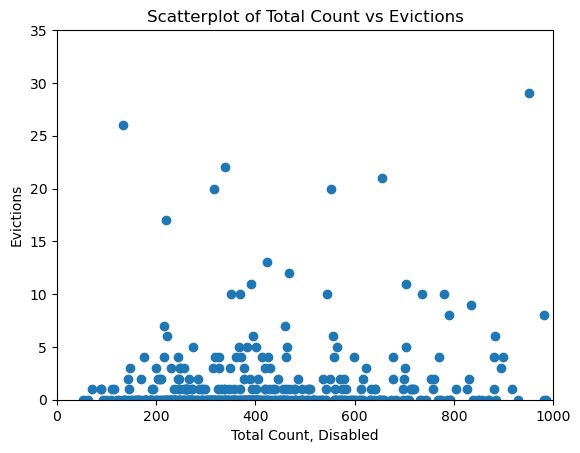

In [88]:
#Full code:

#1: clean eviction data to only include md & pg counties where eviction status is warrant_evicted
eviction_tidy = gdf[gdf['County'].isin(['Montgomery', 'Prince George\'s']) & gdf['EventType'].isin(['Warrant of Restitution - Return of Service - Evicted', 'warrant_evicted'])]
eviction_tidy.head()

#2: combine geojsons for moco & pg counties
#load geojsons
moco_gdf = gpd.read_file('acs2023_5yr_B18101_14000US24031703902.geojson')
pg_gdf = gpd.read_file('acs2023_5yr_B18101_14000US24033805000.geojson')

#check crs
if moco_gdf.crs != pg_gdf.crs:
    pg_gdf = pg_gdf.to_crs(moco_gdf.crs)
    
#combine geojsosn
combined_gdf = pd.concat([moco_gdf, pg_gdf], ignore_index=True)

#3: clean geojson to create count of total with disability in census tract
#remove error columns
combined_gdf = combined_gdf.loc[:, ~combined_gdf.columns.str.contains('Error', case=False)]

#add all disabled count columns 
columns_to_sum = ['B18101004', 'B18101007', 'B18101010', 'B18101013', 'B18101016', 
                  'B18101019', 'B18101023', 'B18101026', 'B18101029', 'B18101032', 
                  'B18101035', 'B18101038']
combined_gdf['total count, disabled'] = combined_gdf[columns_to_sum].sum(axis=1)

#4: spatial join eviction geodataframe to cleaned disability geojson
#confirm crs as UTM18N
utm18n = 32618
combined_gdf = combined_gdf.to_crs(epsg=utm18n)
eviction_tidy = eviction_tidy.to_crs(epsg=utm18n)
assert combined_gdf.crs == eviction_tidy.crs

#spatially join evictions with tracts
tracts_with_evictions_gdf = gpd.sjoin(combined_gdf, eviction_tidy, how='left')
tracts_with_evictions_gdf.head()

# Count unique evictions in each tract
eviction_counts = tracts_with_evictions_gdf.groupby('geoid').index_right.nunique()
eviction_counts

# Join counts onto tracts
tracts_with_counts_gdf = combined_gdf.merge(eviction_counts, left_on='geoid', right_index=True)

#clean-up columns
columns = {
    'geoid':'geoid',
    'total count, disabled':'total count, disabled',
    'index_right':'evictions',
    'geometry':'geometry'
}
tracts_with_counts_gdf = tracts_with_counts_gdf[columns.keys()].rename(columns=columns)
tracts_with_counts_gdf.head()
tracts_with_counts_sorted = tracts_with_counts_gdf.sort_values(by='evictions', ascending = False)
tracts_with_counts_sorted.head(50)

#5 actual: create scatterplot comparing disabled counts with eviction counts

#create scatter plot
plt.scatter(tracts_with_counts_gdf['total count, disabled'], tracts_with_counts_gdf['evictions'])

#set axis limits
plt.xlim(0, 1000)
plt.ylim(0, 35)

#labels and title
plt.xlabel('Total Count, Disabled')
plt.ylabel('Evictions')
plt.title('Scatterplot of Total Count vs Evictions')

#show
plt.show()


#5: map new dataframe as bivariate cloropleth map, with one variable being # of evictions and the other # of people with disability

#handle zeros separately by replacing zeros with NaN temporarily
#tracts_with_counts_gdf['disabled_nonzero'] = tracts_with_counts_gdf['total count, disabled'].replace(0, np.nan)
#tracts_with_counts_gdf['evictions_nonzero'] = tracts_with_counts_gdf['evictions'].replace(0, np.nan)

#normalize into 'low', 'medium', 'high' groups
#tracts_with_counts_gdf['disabled_quartile'] = pd.cut(tracts_with_counts_gdf['disabled_nonzero'].dropna(), 3, labels=["low", "medium", "high"], duplicates='drop')
#tracts_with_counts_gdf['eviction_quartile'] = pd.cut(tracts_with_counts_gdf['evictions_nonzero'].dropna(), 3, labels=["low", "medium", "high"], duplicates='drop')

#fill NaN values (zeros) with the category "low"
#tracts_with_counts_gdf['disabled_quartile'] = tracts_with_counts_gdf['disabled_quartile'].fillna('low')
#tracts_with_counts_gdf['eviction_quartile'] = tracts_with_counts_gdf['eviction_quartile'].fillna('low')

#create bivariate classification column
#tracts_with_counts_gdf['bivariate_class'] = list(zip(tracts_with_counts_gdf['disabled_quartile'], tracts_with_counts_gdf['eviction_quartile']))

#define colors
#color_map = {
    #("low", "low"): "#f7f7f7",        # Light gray for zero (low)
    #("low", "medium"): "#ece7f2",     # Light purple for low-medium
    #("low", "high"): "#d0d1e6",       # Light blue for low-high
    #("medium", "low"): "#67a9cf",     # Light blue for medium-low
    #("medium", "medium"): "#3690c0",  # Blue for medium-medium
    #("medium", "high"): "#02818a",    # Darker blue for medium-high
    #("high", "low"): "#016c6d",       # Dark teal for high-low
    #("high", "medium"): "#003c30",    # Dark teal for high-medium
    #("high", "high"): "#003c30"       # Darkest teal for high-high
#}
#map the 'bivariate_class' to colors
#tracts_with_counts_gdf['color'] = tracts_with_counts_gdf['bivariate_class'].map(color_map)

#create the folium map
#m = folium.Map(location=[tracts_with_counts_gdf.geometry.centroid.y.mean(), tracts_with_counts_gdf.geometry.centroid.x.mean()], zoom_start=9)

# Create a function to get the correct color for each feature based on its 'color' column
#def get_fill_color(feature):
    #geoid = feature['properties']['geoid']  # Replace with the actual key for your identifier
    #color = tracts_with_counts_gdf.loc[tracts_with_counts_gdf['geoid'] == geoid, 'color'].values[0]
    #return color

# Add the choropleth to the map using the get_fill_color function
#folium.GeoJson(
    #tracts_with_counts_gdf,
    #name="choropleth",
    #style_function=lambda feature: {
        #'fillColor': get_fill_color(feature),
        #'fillOpacity': 0.7,
        #'weight': 0.2,
        #'color': 'black'
    #}
#).add_to(m)


#save the map to an HTML file
#m.save("bivariate_choropleth_map.html")

#print map
#m

In [ ]:
#1: clean eviction data to only include md & pg counties where eviction status is warrant_evicted
